In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import random 

solverpath_exe = 'C:\\Users\\Yuri Muniz\\OneDrive\\Documentos\\solvers\\glpk-4.65\\w64\\glpsol'

# Simplified routing problem

Suppose we have $N_f$ fabs and $N_s$ stores with a demand of $D_j$ products each one. We must attend this demand while minimizing the effort of transportation. For simplicity, we consider each product will be shipped alone its cost is linear on the distance between the fab and the store (with the possibility of a fixed term due to shipping). We write the objective function as

$$\min \sum_{ij}x_{ij}D_{ij} + \sum_j c_ix_{ij},$$

where $x_{ij}$ is the amount of products shipped from fab $i$ to store $j$, $D_{ij}$ is the distance between fab $i$ and store $j$, and $c_i$ is the cost per product shipped in fab $i$. The constraints in this simplified problem are the following:

Attend the demand of stores:

$$\sum_i x_{ij} \ge S_j.$$

Achieve the goal of products shipped of each fab:

$$\sum_j x_{ij} \ge F_i^{min}.$$

Fab capacity constraint:

$$\sum_j x_{ij} \le F_i^{max}.$$

In [2]:
# Defining model and parameters
model = AbstractModel()
model.i = Set()
model.j = Set()
model.Demand =Param(model.j) 
model.pmin = Param(model.i)
model.pmax = Param(model.i)
model.Cost = Param(model.i)

model.distance = Param(model.i,model.j, within=Reals)

# Variables and objective function
model.x = Var(model.i,model.j, bounds=(0,300), within=Reals)
model.OF = Var(within=Reals)

# Two constraints can be cast as bounds to the decision variables
def Pbounds(model,i):
    return (model.pmin[i] , model.pmax[i])
model.P = Var(model.i, bounds=Pbounds, domain=Reals)

# Constraints
def rule_C1(model,i):
        return  sum(model.x[i,j] for j in model.j)==model.P[i]
model.C1   = Constraint(model.i,rule=rule_C1)

def rule_C2(model,j):
        return  sum(model.x[i,j] for i in model.i)>=model.Demand[j]
model.C2   = Constraint(model.j,rule=rule_C2)

# Objective
def rule_OF(model):
    return model.OF==sum(model.P[i]*model.Cost[i] for i in model.i) + sum(model.x[i,j]*model.distance[i,j] for i in model.i for j in model.j)
model.C3   = Constraint(rule=rule_OF)
model.obj1 = Objective(expr=model.OF, sense=minimize)


In [3]:
opt = SolverFactory('glpk', executable=solverpath_exe)
instance = model.create_instance("transportation_data.dat")
results = opt.solve(instance) # solves and updates instance
print('OF= ',value(instance.OF))


OF=  10730.0


In [4]:
for i in instance.i:
    print(value(instance.P[i]),value(instance.pmin[i]),value(instance.pmax[i]))
    for j in instance.j:
        print((i,j),value(instance.x[i,j]))

300.0 0 900
(1, 1) 0.0
(1, 2) 0.0
(1, 3) 300.0
(1, 4) 0.0
620.0 10 850
(2, 1) 210.0
(2, 2) 170.0
(2, 3) 120.0
(2, 4) 120.0
20.0 20 750
(3, 1) 0.0
(3, 2) 20.0
(3, 3) 0.0
(3, 4) 0.0


(0.06, 0.9400000000000001, 0.06, 0.9400000000000001)

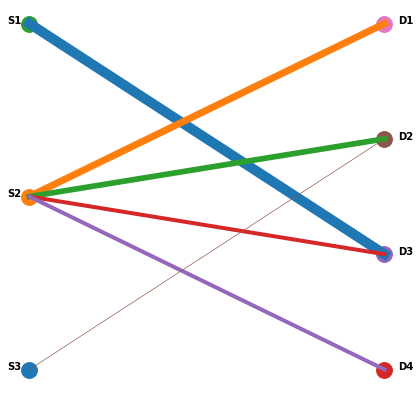

In [5]:
fig = plt.figure(figsize=(7,7))
Ni=3
Nj=4
supplyY=np.linspace(0.1,0.9,Ni)
supplyX=0.1*np.ones_like(supplyY)
demandY=np.linspace(0.1,0.9,Nj)
demandX=0.9*np.ones_like(demandY)

for i in instance.i:
    for j in instance.j:
        if value(instance.x[i,j])>0.1:
            plt.plot([supplyX[Ni-i],demandX[Nj-j]],[supplyY[Ni-i],demandY[Nj-j]],lw=value(instance.x[i,j])/30)
for c in range(0,Ni):
    plt.scatter(supplyX[c],supplyY[c],s=250)
    plt.text(supplyX[Ni-c-1]-0.05,supplyY[Ni-c-1],'S'+str(c+1),fontweight='bold')
for c in range(0,Nj):
    plt.scatter(demandX[c],demandY[c],s=250)
    plt.text(demandX[Nj-c-1]+0.03,demandY[Nj-c-1],'D'+str(c+1),fontweight='bold')
plt.axis('off')
